# 🔬 Bayesian Regime Detection with Gaussian Mixture Models

**Author:** Iliya Nanov  
**Date:** 2025-07-17  
**Tags:** `Bayesian Inference` · `GMM` · `MCMC` · `Quantitative Finance` · `Colab`  
**GitHub:** [github.com/iNANOV/quant-models-lab](https://github.com/iNANOV/quant-models-lab/tree/main/experiments/bayesian_gmm_mcmc)

---

This notebook explores the use of **Bayesian inference** to identify market regimes  
using **Gaussian Mixture Models** estimated via **Metropolis-Hastings MCMC sampling**.  
It evaluates the predictive power of regime signals on short-term returns.


# 📘 Abstract

This study explores a probabilistic approach to detecting the onset of market crashes through a **Bayesian inference** framework. A **Gaussian Mixture Model (GMM)** is applied to financial return data that has been **detrended and volatility-adjusted**, aiming to approximate three distinct market regimes: **strong bear**, **bear**, and **bull** markets.

To estimate the latent state probabilities, a **Metropolis-Hastings Markov Chain Monte Carlo (MCMC)** sampler is employed, providing a posterior distribution over regime assignments. The model identifies periods where the probability of the strong bear regime exceeds 50%, marking these moments on a **weekly bar plot** as potential early indicators of market distress.

> 🧠 While the model is not designed for predictive accuracy, it serves as a transparent and interpretable demonstration of MCMC in a real-world financial context, offering insights into regime shifts and probabilistic reasoning in time series analysis.


# 🔧 Data & Functions & Packages

In [ ]:
pip install mplfinance

In [2]:
# Force overwrite by renaming explicitly
!wget -O functions.py https://raw.githubusercontent.com/iNANOV/quant-models-lab/main/experiments/bayesian_gmm_mcmc/functions.py

import importlib.util

spec = importlib.util.spec_from_file_location("functions", "./functions.py")
functions = importlib.util.module_from_spec(spec)
spec.loader.exec_module(functions)

# Verify all functions
print([f for f in dir(functions) if not f.startswith("_")])


--2025-07-17 12:36:14--  https://raw.githubusercontent.com/iNANOV/quant-models-lab/main/experiments/bayesian_gmm_mcmc/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16762 (16K) [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]  16.37K  --.-KB/s    in 0.005s  

2025-07-17 12:36:14 (3.54 MB/s) - ‘functions.py’ saved [16762/16762]

['GaussianMixture', 'annotate_signals_and_returns', 'bayesian_gmm_mcmc', 'beta', 'compute_gamma_t', 'evaluate_negative_returns_after_signals_with_prices', 'generate_performance_table', 'halfnorm', 'mpf', 'norm', 'np', 'pd', 'plot_gmm_vs_posterior', 'plot_regime_probabilities', 'plot_upward_crossings', 'plt', 'sns']


In [3]:
import yfinance as yf
import pandas as pd

# Download data
ticker = yf.Ticker("^GSPC")
data = ticker.history(start="2000-01-01")

# Check if data is empty
print("Raw data shape:", data.shape)

# Remove timezone if present
data.index = data.index.tz_localize(None)

# Resample to weekly (Friday close)
df = data.resample('W-FRI').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

# Final formatting
df.reset_index(inplace=True)
df.columns = df.columns.str.lower()

df

Raw data shape: (6422, 7)


,date,open,high,low,close,volume
0,2000-01-07,1469.250000,1478.000000,1377.680054,1441.469971,5343800000
1,2000-01-14,1441.469971,1473.000000,1427.079956,1465.150024,5169700000
2,2000-01-21,1465.150024,1465.709961,1438.540039,1441.359985,4455000000
3,2000-01-28,1441.359985,1454.089966,1356.199951,1360.160034,5532100000
4,2000-02-04,1360.160034,1435.910034,1350.140015,1424.369995,5205000000
...,...,...,...,...,...,...
1328,2025-06-20,6004.000000,6050.830078,5952.560059,5967.839844,22625380000
1329,2025-06-27,5969.669922,6187.680176,5943.229980,6173.069824,29409290000
1330,2025-07-04,6193.359863,6284.649902,6174.970215,6279.350098,21082030000
1331,2025-07-11,6259.040039,6290.220215,6201.000000,6259.750000,25812670000


# 🧠 Model

## Weighted Moving Average and Detrended Return Formulas

---

### 📐 **Weighted Moving Average (WMA)**

The **Weighted Moving Average** of `open` prices over a window size *n* with weights *wₖ = k* is defined as:

$$
\mathrm{WMA}_t = \frac{\sum_{k=1}^{n} w_k \cdot \mathrm{open}_{t-n+k}}{\sum_{k=1}^{n} w_k}
$$

Where:  
- *openₜ*: Open price at time *t*  
- *wₖ = k*: Weights increasing linearly from 1 to *n*

---

### 📉 **Detrended Open**

The **detrended open** is calculated as:

$$
\mathrm{detrended\_open}_t = \frac{\mathrm{open}_t}{\mathrm{WMA}_{t-1}} - 1
$$

Where *WMAₜ₋₁* is the lagged WMA.

---

### 📏 **Range Factor**

The **range factor** measures the high-low range relative to the low price:

$$
\mathrm{range\_factor}_t = 1 + \frac{\mathrm{high}_t - \mathrm{low}_t}{\mathrm{low}_t + \epsilon}
$$

Where:  
- *epsilon*: A small constant (e.g., 1e-6) to avoid division by zero.

---

### 📈 **Weighted Detrended Return**

The final **weighted detrended return** is computed as:

$$
\mathrm{return}_t = \mathrm{detrended\_open}_t \cdot \mathrm{range\_factor}_t
$$

---

### 📝 **Original Full Formula (Alternative)**

Alternatively, the original formula you commented in code can be written as:

$$
\mathrm{return}_t =
\left( \frac{\mathrm{high}_t - \mathrm{low}_t}{\mathrm{low}_t} + 1 \right)
\cdot \mathrm{WMA}_{t-1}
\cdot
\frac{
\mathrm{WMA}_{t-1} \cdot \mathrm{open}_t - \mathrm{WMA}_t \cdot \mathrm{open}_{t-1}
}{
\mathrm{open}_{t-1} - \mathrm{WMA}_{t-1}
}
$$

Where:  
- *highₜ*, *lowₜ*, *openₜ*: High, low, and open prices at time *t*  
- *WMAₜ*: Weighted moving average at time *t*

---


In [4]:
import pandas as pd
import numpy as np

# WMA parameters
n = 26  # window length
weights = np.arange(1, n + 1)

def weighted_moving_average(series, n):
    def wma(x):
        return (x * weights).sum() / weights.sum()
    return series.rolling(n).apply(wma, raw=True)

# Compute WMA for open prices
df['wma_open'] = weighted_moving_average(df['open'], n)

# Compute detrended return
df['detrended_open'] = (df['open'] / df['wma_open'].shift(1)) - 1

# Compute range factor
df['range_factor'] = 1 + (df['high'] - df['low']) / (df['low'] + 1e-6)

# Weighted detrended return
df['return'] = df['detrended_open'] * df['range_factor']

# Split train/test
start_date = '2023-12-31'
df_train = df[df['date'] < start_date].copy()
df_test = df[df['date'] >= start_date].copy()

# Clean NA from WMA in train
df_train = df_train.dropna(subset=['return'])

## Bayesian Inference of Gaussian Mixture Models using MCMC (Metropolis-Hastings)
---

### 1. Data and Goal

We are given a dataset of observed returns:  

$$
x = \{x_1, x_2, \dots, x_N\}.
$$

The goal is to model $x$ as a mixture of $K=3$ Gaussian distributions and infer the parameters of the mixture using **Bayesian inference**.  

Each observation $x_i$ is assumed to be drawn from:  

$$
p(x_i \mid \Theta) = \sum_{k=1}^3 \pi_k \, \mathcal{N}(x_i \mid \mu_k, \sigma_k^2),
$$

where:

- $\mu_k$: mean of Gaussian component $k$,
- $\sigma_k$: standard deviation of Gaussian component $k$,
- $\pi_k$: mixing weight of component $k$, subject to:  

$$
\pi_k \ge 0, \quad \sum_{k=1}^3 \pi_k = 1,
$$

- $\mathcal{N}(x_i \mid \mu_k, \sigma_k^2)$: Gaussian probability density function.

The parameter set is:

$$
\Theta = \{\mu_k, \sigma_k, \pi_k \mid k = 1, 2, 3\}.
$$

---

### 2. Likelihood Function

The likelihood of observing all data $x_1, \dots, x_N$ given parameters $\Theta$ is:

$$
L(\Theta) = \prod_{i=1}^N p(x_i \mid \Theta),
$$

or in log form (log-likelihood):

$$
\log L(\Theta) = \sum_{i=1}^N \log \left( \sum_{k=1}^3 \pi_k \, \mathcal{N}(x_i \mid \mu_k, \sigma_k^2) \right).
$$

This measures how well the parameters $\Theta$ explain the observed data.

---

### 3. Priors on Parameters

To perform Bayesian inference, we impose **prior distributions** on the parameters.

---

#### a) Prior on Means $\mu_k$

Each mean $\mu_k$ is assigned a **normal prior** centered around an initial estimate $\mu_{k,\mathrm{init}}$:

$$
p(\mu_k) = \mathcal{N}(\mu_k \mid \mu_{k,\mathrm{init}}, \tau^2),
$$

with $\tau$ a small standard deviation (e.g., $\tau = 0.02$).  

This encourages $\mu_k$ to stay close to the initialized values while allowing some flexibility:

$$
\log p(\mu_k) = -\frac{1}{2} \log(2\pi\tau^2) - \frac{(\mu_k - \mu_{k,\mathrm{init}})^2}{2\tau^2}.
$$

---

#### b) Prior on Standard Deviations $\sigma_k$

Each standard deviation $\sigma_k$ is assigned a **half-normal prior**:

$$
p(\sigma_k) = \mathrm{HalfNormal}(\sigma_k \mid \eta),
$$

where $\eta$ is a small scale parameter (e.g., $\eta = 0.02$). This prior penalizes large variances and ensures $\sigma_k > 0$:

$$
\log p(\sigma_k) = \log\left(\frac{\sqrt{2}}{\eta\sqrt{\pi}}\right) - \frac{\sigma_k^2}{2\eta^2}.
$$

In addition, we impose **hard constraints**:

$$
\sigma_k \in [0.005, 0.5],
$$

rejecting any $\sigma_k$ outside this range.

---

#### c) Prior on Mixing Weights $\pi_k$

Each mixture weight $\pi_k$ is assigned a **Beta prior**:

$$
p(\pi_k) = \mathrm{Beta}(\pi_k \mid \alpha, \beta),
$$

with $\alpha=\beta=5$ to avoid extreme values near 0 or 1:

$$
\log p(\pi_k) = (\alpha-1)\log(\pi_k) + (\beta-1)\log(1-\pi_k) - \log B(\alpha,\beta).
$$

Finally, a **penalty term** ensures weights sum to 1:

$$
\mathrm{Penalty} = -C \cdot \left|\sum_{k=1}^3 \pi_k - 1\right|,
$$

with $C$ a large constant.

---

#### d) Total Log-Prior

The total log-prior is:

$$
\log p(\Theta) = \sum_{k=1}^3 \left[\log p(\mu_k) + \log p(\sigma_k) + \log p(\pi_k)\right] + \mathrm{Penalty}.
$$

---

### 4. Posterior Distribution

By Bayes’ theorem, the posterior distribution is proportional to:

$$
p(\Theta \mid x) \propto L(\Theta) \cdot p(\Theta),
$$

or equivalently in log form:

$$
\log p(\Theta \mid x) = \log L(\Theta) + \log p(\Theta).
$$

This is the distribution we want to sample from.

---

### 5. Metropolis-Hastings Sampling

To draw samples from $p(\Theta \mid x)$, we use the Metropolis-Hastings algorithm:

1. **Initialization**:  
   Start with initial parameters  
   $$
   \Theta^{(0)} = \{\mu_k^{(0)}, \sigma_k^{(0)}, \pi_k^{(0)}\}.
   $$

2. **Proposal Step**:  
   Propose new parameters $\Theta'$ by adding small random noise:
   $$
   \begin{aligned}
   \mu_k' &= \mu_k + \epsilon_\mu, \\
   \log \sigma_k' &= \log \sigma_k + \epsilon_\sigma, \\
   \pi_k' &= \pi_k + \epsilon_\pi,
   \end{aligned}
   $$

   where $\epsilon_\mu, \epsilon_\sigma, \epsilon_\pi$ are drawn from zero-mean Gaussians.

   Normalize $\pi_k'$ so that $\sum_k \pi_k' = 1$. Enforce ordering $\mu_1' \leq \mu_2' \leq \mu_3'$ to avoid label-switching.

3. **Acceptance Probability**:  
  To decide whether to accept a proposed set of parameters $ \Theta' $ given current parameters $ \Theta $, compute:

  $ \alpha = \min\left(1,\ \exp\left[\log p(\Theta' \mid x) - \log p(\Theta \mid x)\right]\right) $

  - If $ \log p(\Theta' \mid x) > \log p(\Theta \mid x) $, then $ \alpha = 1 $, and the proposal is **always accepted**.
  - Otherwise, the proposal is accepted with probability $ \alpha $.

  This is implemented by drawing a random number $ u \sim \text{Uniform}(0, 1) $, for example using `np.random.rand()`, and accepting the move if:

    $ u < \alpha $

  This allows the sampler to occasionally accept lower-probability moves, helping it escape local optima and better explore the full posterior distribution.


4. **Iteration**:  
   Repeat steps 2–3 for many iterations to produce a Markov chain whose stationary distribution is $p(\Theta \mid x)$.

---

### 6. Posterior Estimates

After discarding initial "burn-in" samples and thinning, compute posterior expectations:

$$
\begin{aligned}
\hat{\mu}_k &= \mathbb{E}[\mu_k], \\
\hat{\sigma}_k &= \mathbb{E}[\sigma_k], \\
\hat{\pi}_k &= \mathbb{E}[\pi_k].
\end{aligned}
$$

These are the Bayesian estimates of the mixture parameters.

---

### Key Insights

✅ The priors ensure parameter identifiability and prevent degenerate solutions (e.g., weights collapsing to 0 or variances becoming extreme).  
✅ Metropolis-Hastings allows sampling from the posterior even if the posterior is complex and not analytically tractable.  
✅ Ordering the means $\mu_1 \leq \mu_2 \leq \mu_3$ avoids the label-switching problem common in mixture models.


# 🏋️ Train Model

## ✅ Summary of Parameters in Bayesian GMM

| **Symbol**      | **Meaning**                                     | **Code (Python)**           | **Distribution (Prior)**                            | **Visual**        |
|-----------------|------------------------------------------------|-----------------------------|-----------------------------------------------------|-------------------|
| $\mu_k$         | Mean return of component $k$                    | `mu[k]`                    | **Normal**: $\mathcal{N}(\mu_{init}, \sigma_{prior}^2)$ | ▁▂▄▆█▆▄▂▁          |
| $\sigma_k$      | Volatility (standard deviation) of component $k$| `np.exp(log_sigma[k])`     | **Half-Normal**: $\mathcal{HN}(\sigma_{scale})$     | ▁▂▃▄▆▇██           |
| $\pi_k$         | Mixing weight (probability) of component $k$    | `pi[k]`                    | **Beta**: $\text{Beta}(\alpha, \beta)$              | ▁▂▄▇█▇▄▂▁          |
| $\mu_0$         | Bear regime mean return                         | `mu[0]`                    | **Normal**                                          | ▁▂▄▆█▆▄▂▁          |
| $\mu_1$         | Neutral/stable regime mean return               | `mu[1]`                    | **Normal**                                          | ▁▂▄▆█▆▄▂▁          |
| $\mu_2$         | Bull regime mean return                         | `mu[2]`                    | **Normal**                                          | ▁▂▄▆█▆▄▂▁          |
| $\sigma_0$      | Bear regime volatility                          | `np.exp(log_sigma[0])`     | **Half-Normal**                                     | ▁▂▃▄▆▇██           |
| $\sigma_1$      | Neutral regime volatility                       | `np.exp(log_sigma[1])`     | **Half-Normal**                                     | ▁▂▃▄▆▇██           |
| $\sigma_2$      | Bull regime volatility                          | `np.exp(log_sigma[2])`     | **Half-Normal**                                     | ▁▂▃▄▆▇██           |
| $\pi_0$         | Probability of bear regime                      | `pi[0]`                    | **Beta**                                            | ▁▂▄▇█▇▄▂▁          |
| $\pi_1$         | Probability of neutral regime                   | `pi[1]`                    | **Beta**                                            | ▁▂▄▇█▇▄▂▁          |
| $\pi_2$         | Probability of bull regime                      | `pi[2]`                    | **Beta**                                            | ▁▂▄▇█▇▄▂▁          |
| $\Theta$        | Full parameter set $(\mu, \sigma, \pi)$         | `mu, log_sigma, pi`        | Combined posterior from likelihood & priors         | (composite)        |

---

# 🟢 MCMC Hyperparameters

| **Parameter**         | **Meaning**                                                        | **Code (Python)**      | **Prior Distribution**                          | **Visual**        |
|-----------------------|--------------------------------------------------------------------|-----------------------|------------------------------------------------|-------------------|
| `prior_mu_std`        | Std dev of Normal prior on $\mu_k$                                | `prior_mu_std`        | $\mathcal{N}(\mu_{init}, \sigma_{prior}^2)$   | ▁▂▄▆█▆▄▂▁          |
| `prior_sigma_scale`   | Scale of Half-Normal prior on $\sigma_k$                          | `prior_sigma_scale`   | $\mathcal{HN}(\sigma_{scale})$                 | ▁▂▃▄▆▇██           |
| `prior_pi_alpha`      | Alpha parameter for Beta prior on $\pi_k$                         | `prior_pi_alpha`      | $\text{Beta}(\alpha, \beta)$                   | ▁▂▄▇█▇▄▂▁          |
| `prior_pi_beta`       | Beta parameter for Beta prior on $\pi_k$                          | `prior_pi_beta`       | $\text{Beta}(\alpha, \beta)$                   | ▁▂▄▇█▇▄▂▁          |
| `sigma_bounds`        | Lower/upper bounds on $\sigma_k$ (controls $\sigma_k$)            | `sigma_bounds`        | Hard constraint: $\sigma_{min} \leq \sigma_k \leq \sigma_{max}$ | ▀▀▀▀▀▀▀▀           |
| `penalty_weight`      | Penalty enforcing $\sum \pi_k = 1$                                | `penalty_weight`      | Soft constraint added as penalty term           | (none)             |

---

# 📈 Outputs to Examine

| **Output**             | **Meaning**                                                         | **Code (Python)**               | **Distribution (Posterior)**               | **Visual**        |
|------------------------|----------------------------------------------------------------------|---------------------------------|----------------------------------------------|-------------------|
| `samples['mu']`        | Posterior samples of $\mu_k$ (mean returns of each regime)          | `samples['mu'][:, k]`            | Posterior (Normal likelihood + Normal prior) | ▁▂▄▆█▆▄▂▁          |
| `samples['log_sigma']` | Posterior samples of $\log \sigma_k$; exponentiate to get $\sigma_k$| `np.exp(samples['log_sigma'][:, k])` | Posterior (Log-scale with Half-Normal prior) | ▁▂▃▄▆▇██           |
| `samples['pi']`        | Posterior samples of mixing weights $\pi_k$                         | `samples['pi'][:, k]`            | Posterior (Dirichlet-like from Beta priors + constraints) | ▁▂▄▇█▇▄▂▁          |


📊 GMM Initialization:
μ: [-0.1146969  -0.02820143  0.03470171]
log(σ): [-2.32484018 -3.24207297 -3.60916045]
π: [0.05898006 0.27310423 0.66791571]
✅ Acceptance rate: 84.54%
Posterior μ: [-0.11248233 -0.03009184  0.0326367 ]
Posterior σ: [0.08663101 0.04107947 0.02879947]
Posterior π: [0.06711735 0.24046196 0.69242069]


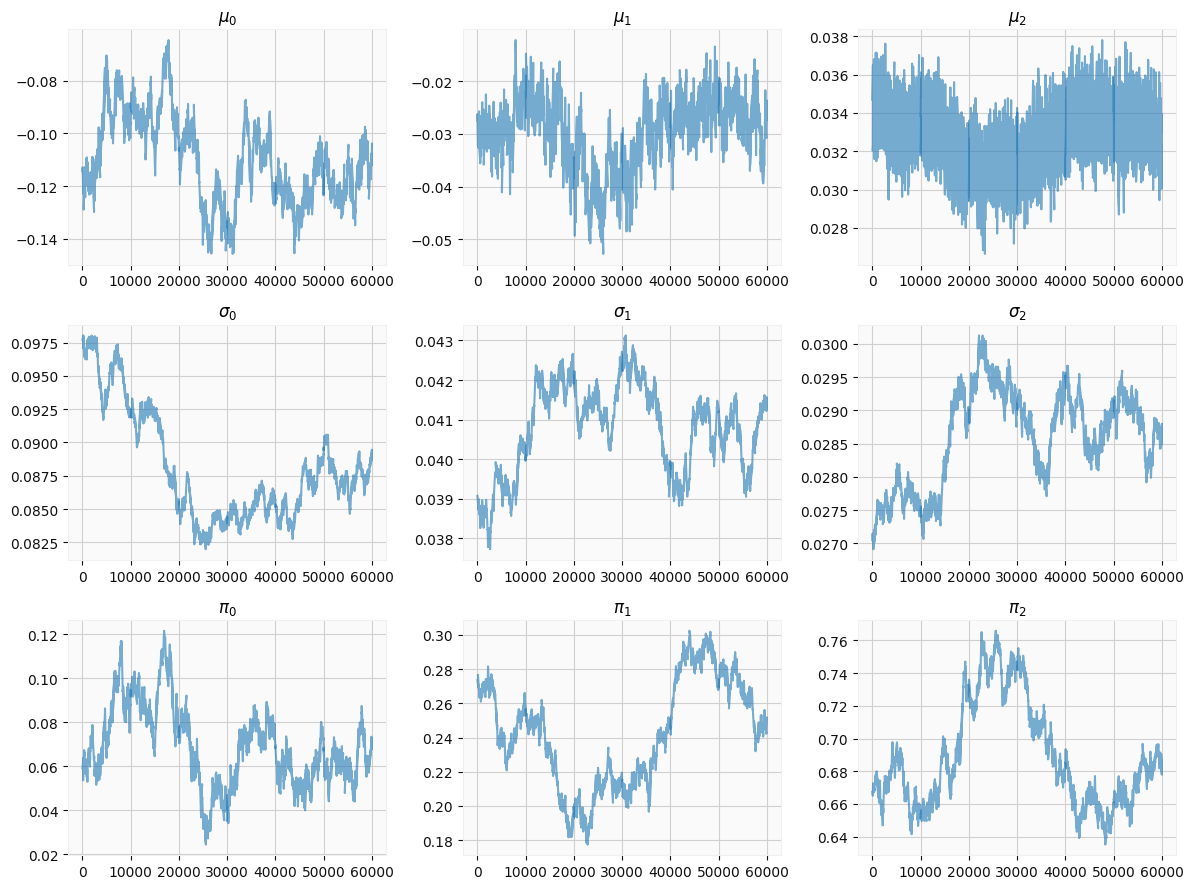

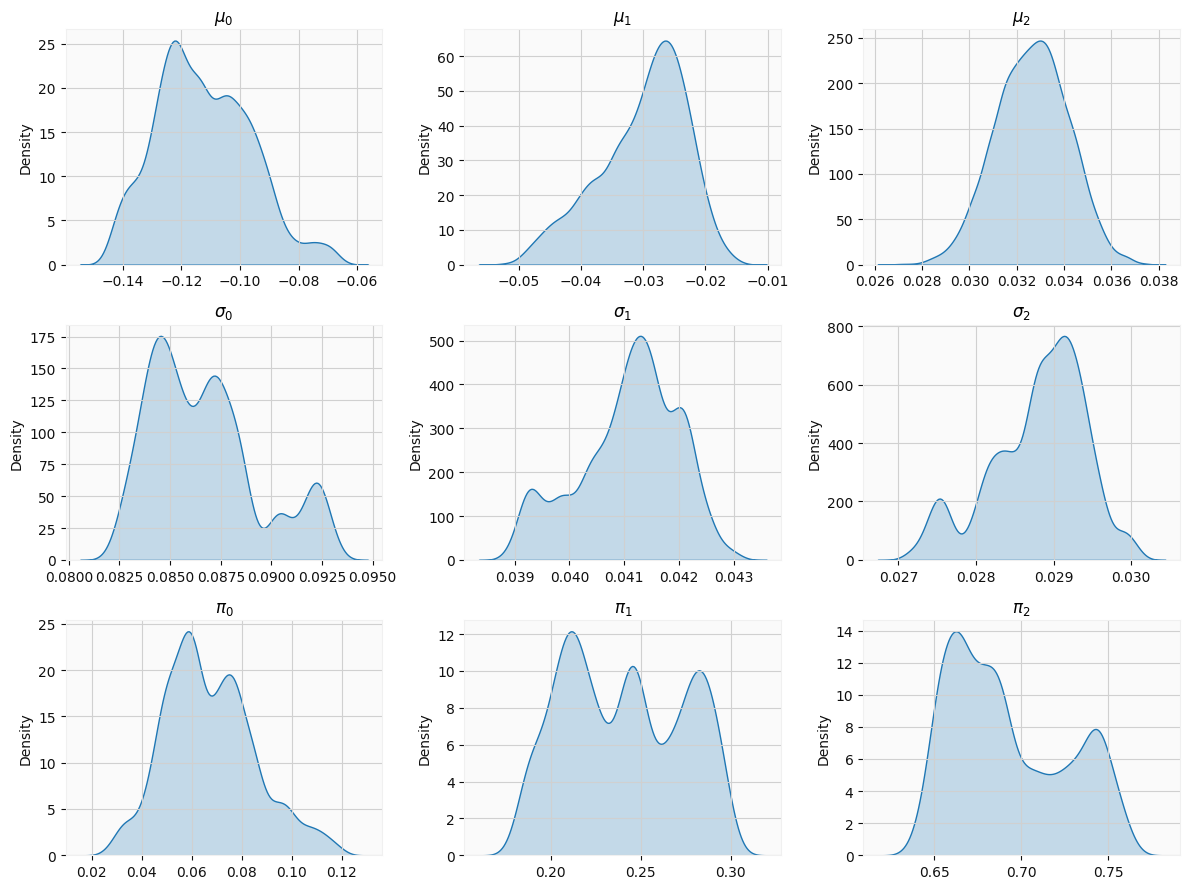

In [34]:
# Example: Run Bayesian GMM MCMC
samples = functions.bayesian_gmm_mcmc(

    # === INPUT DATA ===
    data=df_train['return'].values,      # The array of observed data (e.g., returns). Should be a 1D numpy array.

    # === GMM MODEL PARAMETERS ===
    n_components=3,                      # Number of Gaussian components in the mixture (e.g., 3 = bear/bear/bull regimes)
    random_state=42,                     # Seed for random number generators (ensures reproducibility)

    # === PRIORS ON PARAMETERS ===
    prior_mu_std=0.02,                   # Standard deviation for Normal prior on means μₖ
                                         # (small values = tightly pull μₖ to GMM-initialized means)
    prior_sigma_scale=0.02,              # Scale parameter for Half-Normal prior on σₖ
                                         # (small = favors compact clusters, large = allows more spread)
    prior_pi_alpha=5,                    # Alpha parameter for Beta prior on mixing weights πₖ
                                         # (higher = discourages πₖ being too small or too large)
    prior_pi_beta=5,                     # Beta parameter for Beta prior on πₖ
                                         # (together with alpha controls the shape of the prior on weights)
    sigma_bounds=(0.005, 0.5),           # Hard bounds on σₖ: prevents variances being too small/large

    # === PENALTIES ===
    penalty_weight=1000,                 # Penalty for deviations of sum(πₖ) from 1
                                         # (larger value = stronger enforcement that weights sum to 1)

    # === MCMC SAMPLING SETTINGS ===
    n_samples=60000,                     # Total number of MCMC iterations (more = better posterior approximation)
    step_size=0.0005,                    # Proposal step size for parameter updates in Metropolis-Hastings
                                         # (smaller = higher acceptance rate, but slower exploration)
    burn_in=10000,                       # Number of initial samples to discard (burn-in phase)
    thin=10,                             # Thinning factor: keeps every N-th sample to reduce autocorrelation

    # === PLOTTING OPTIONS ===
    plot_traces=True,                    # If True, plot trace plots of sampled parameters over iterations
    plot_densities=True                  # If True, plot kernel density estimates (posterior distributions)
)


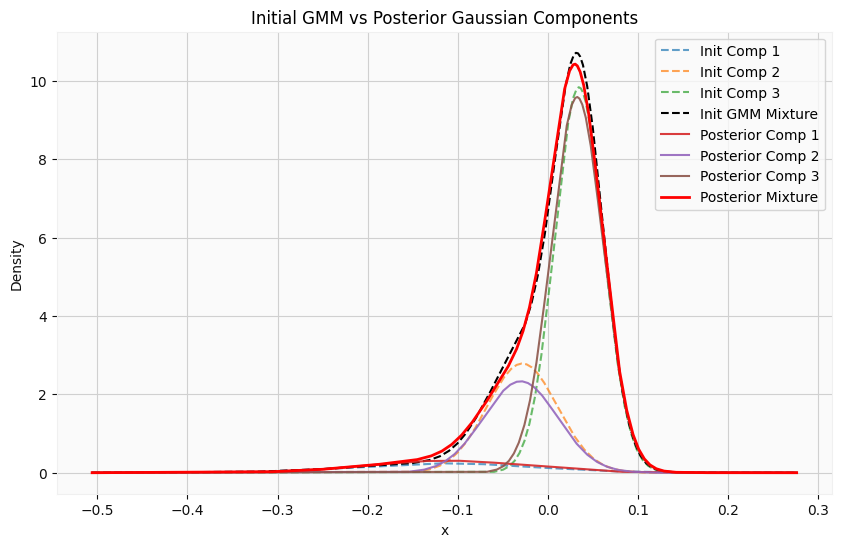

In [35]:
thinned_samples = samples[0]  # MCMC samples after burn-in and thinning
mu_init = samples[1] # Initial means from GMM
log_sigma_init = samples[2] # Initial log std devs from GMM
pi_init = samples[3] # Initial component weights from GMM
mu_post = samples[4] # Posterior means from MCMC
sigma_post = samples[5] # Posterior std devs from MCMC
pi_post = samples[6] # Posterior weights from MCMC

# Plot initial GMM vs posterior (μ, σ, π)
functions.plot_gmm_vs_posterior(mu_init, log_sigma_init, pi_init, mu_post, sigma_post, pi_post)

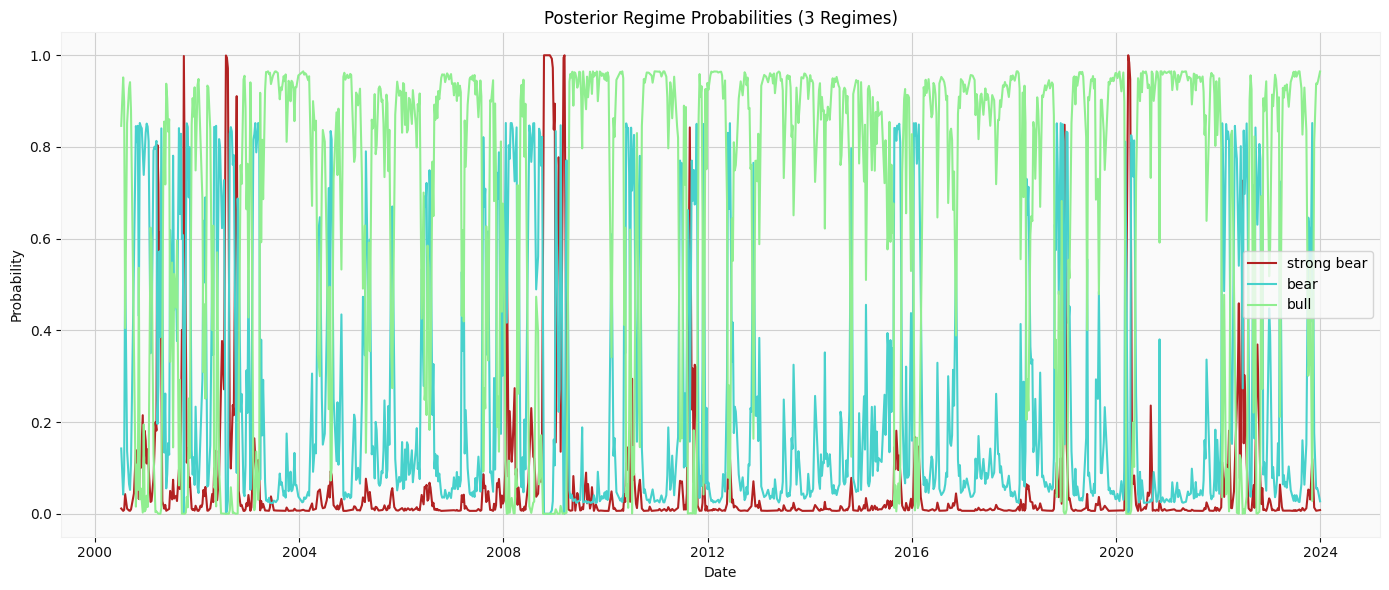

In [36]:
returns = df_train['return'].values
dates = df_train['date']
labels = ['strong bear', 'bear', 'bull']
colors = ['firebrick', 'mediumturquoise', 'lightgreen']


functions.plot_regime_probabilities(returns, mu_post, sigma_post,
                                    pi_post, dates=dates,labels=labels,colors=colors)

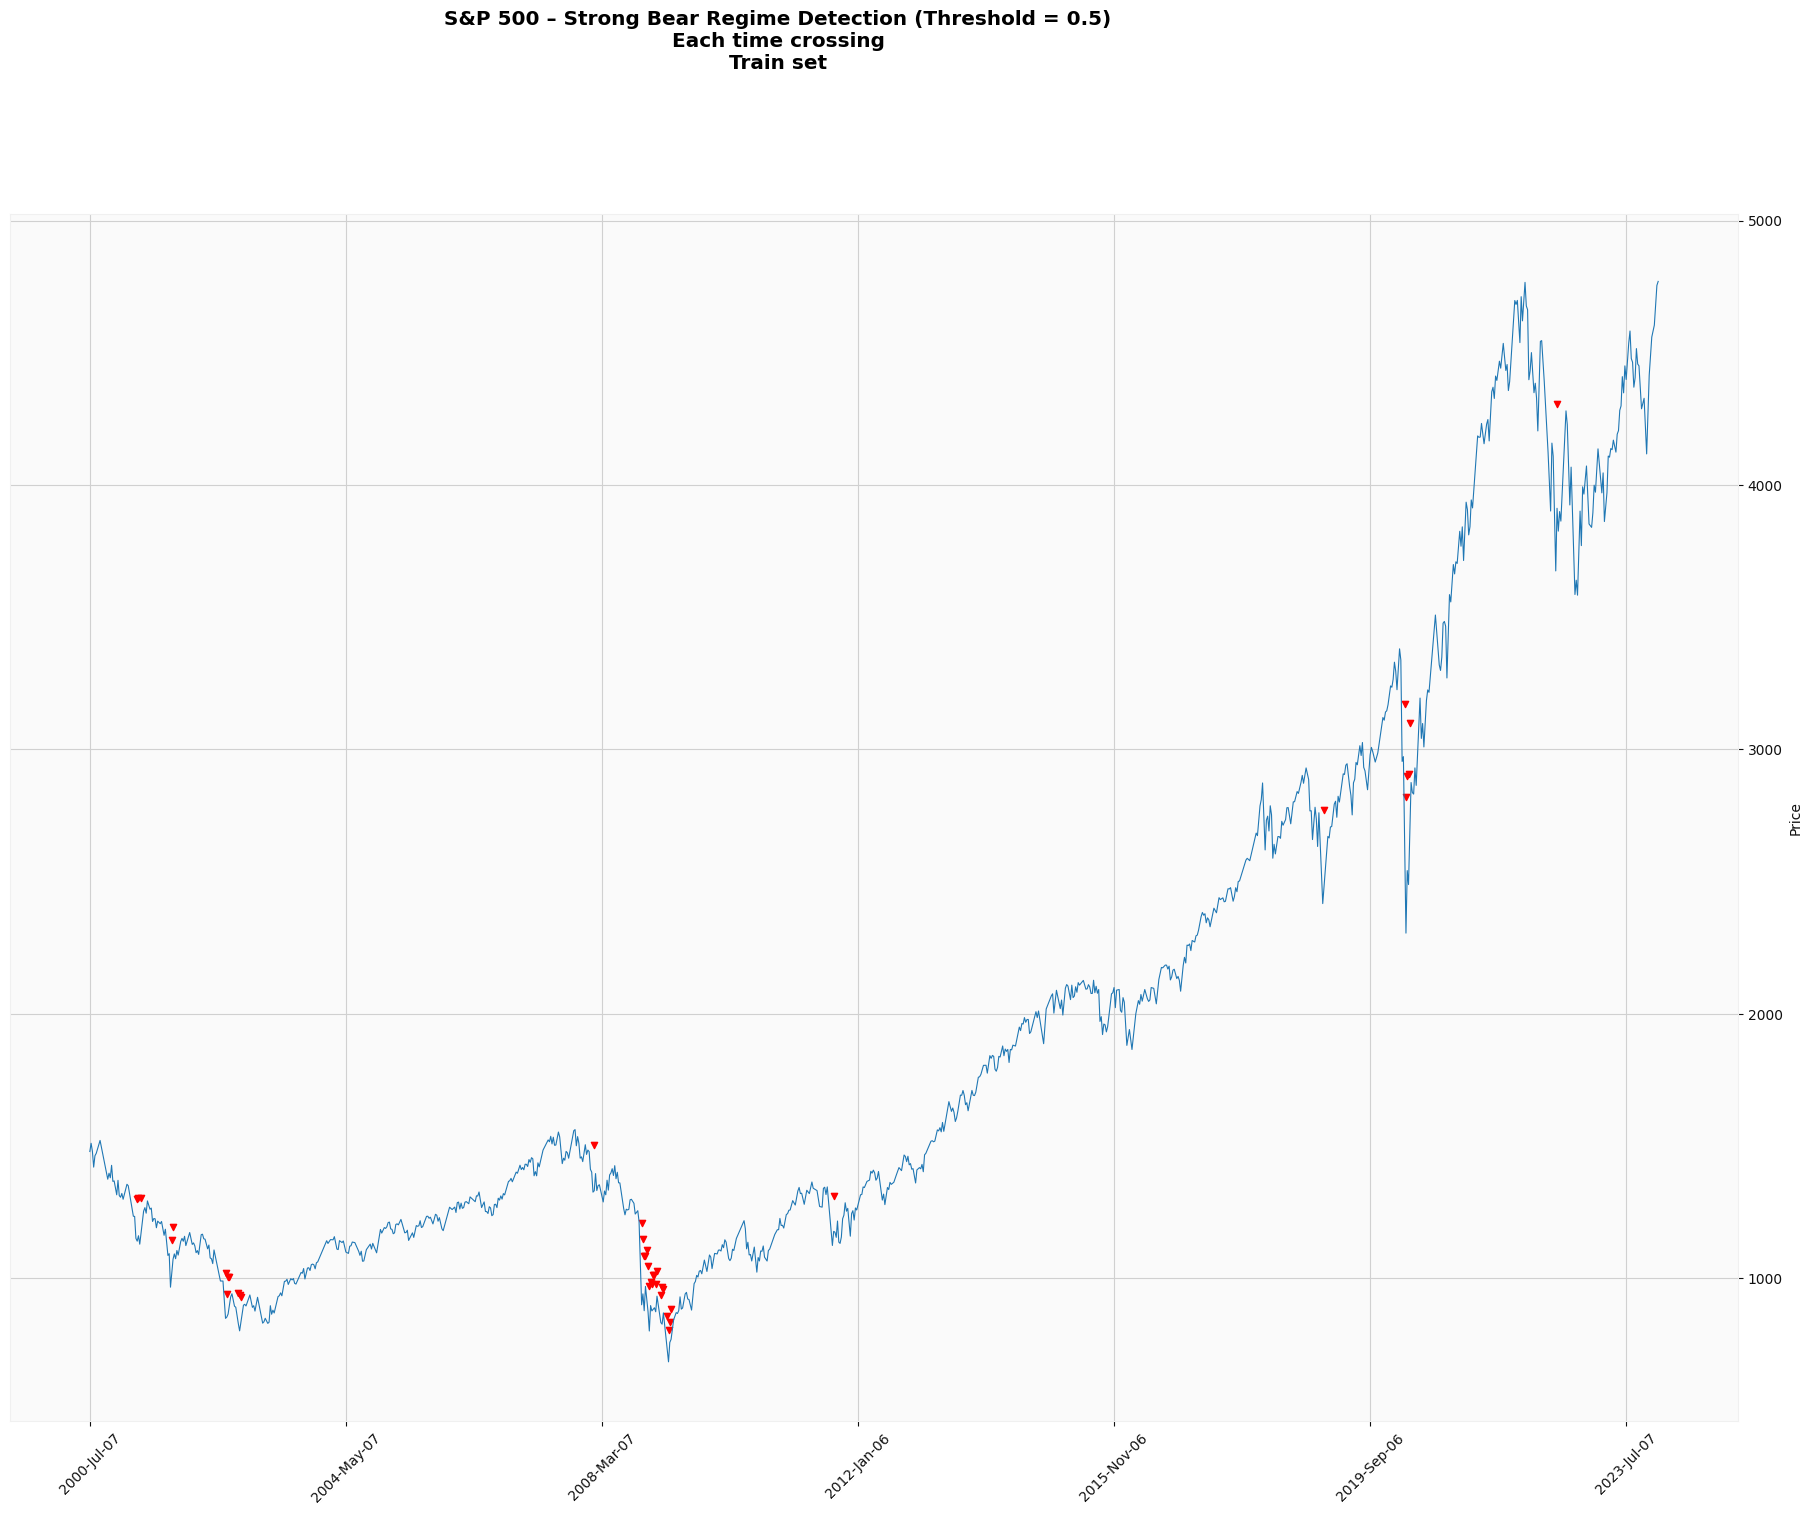

In [37]:
import mplfinance as mpf
import numpy as np

# Convert 'date' column to datetime if not already
df_train['date'] = pd.to_datetime(df_train['date'])

# Set 'date' column as index (a DatetimeIndex)
df_train_dt = df_train.set_index('date').copy()

returns = df_train_dt['return'].values  # use the datetime-indexed df
gamma_t = functions.compute_gamma_t(returns, mu_post, sigma_post, pi_post)

strong_bear_threshold = 0.5
strong_bear_mask = gamma_t[:, 0] > strong_bear_threshold

marker_positions = np.where(strong_bear_mask, df_train_dt['high'] * 1.1, np.nan)

apdict = mpf.make_addplot(marker_positions, type='scatter',
                          markersize=20, marker='v', color='red')

mpf.plot(df_train_dt, type='line', style='yahoo', addplot=apdict,
         title=f'S&P 500 – Strong Bear Regime Detection (Threshold = {strong_bear_threshold})\nEach time crossing\nTrain set',
         ylabel='Price', volume=False, figscale=3)


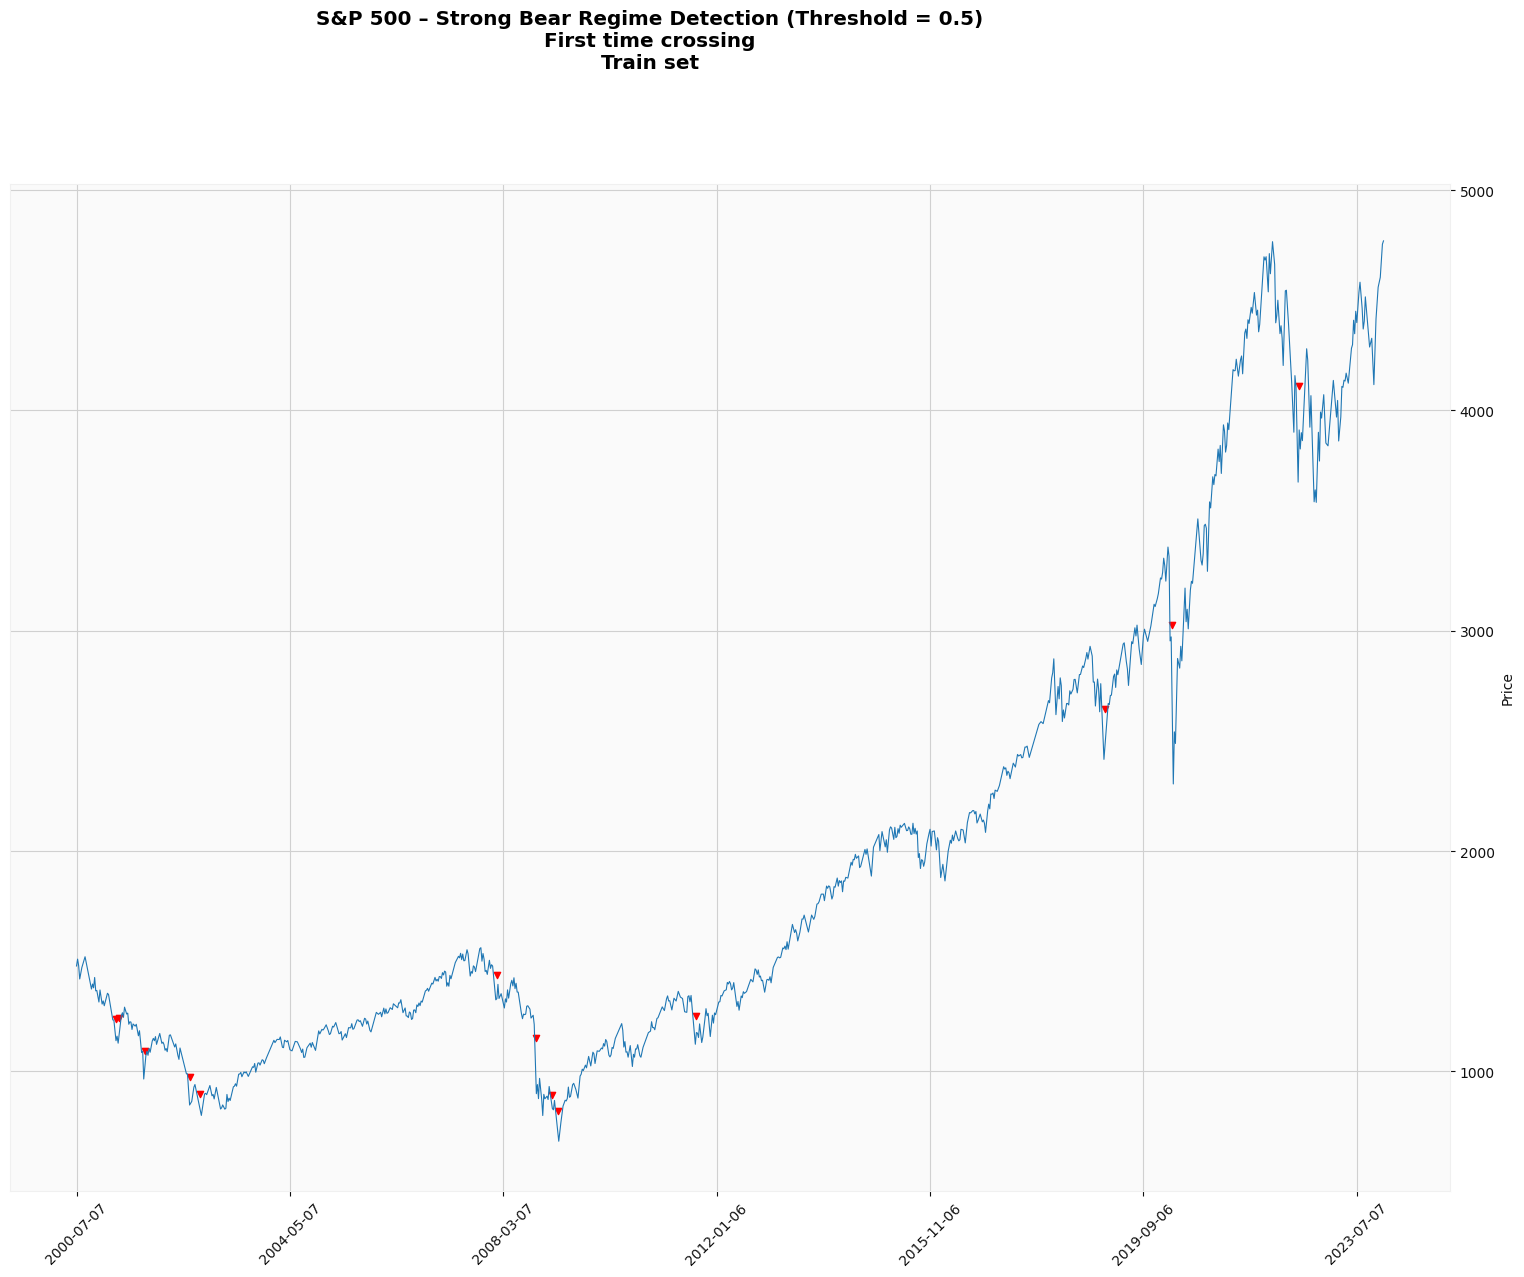

In [38]:
import pandas as pd
import numpy as np
import mplfinance as mpf

# upward crossing of
threshold = 0.5

functions.plot_upward_crossings(
    df_train,
    gamma_probs=gamma_t[:, 0], # strong bear
    threshold=threshold,
    marker_type='v',
    marker_size=20,
    marker_color='red',
    title=f'S&P 500 – Strong Bear Regime Detection (Threshold = {threshold})\nFirst time crossing\nTrain set',
    figscale=2.5
)


# 🧪 Test Model

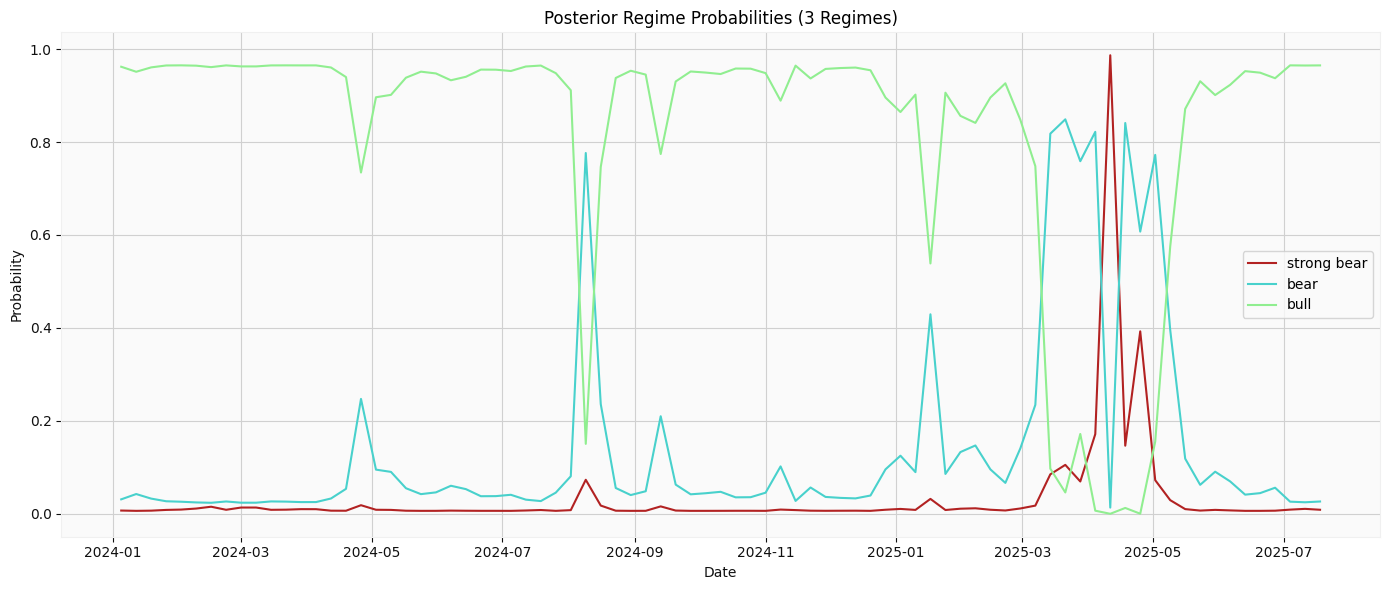

In [39]:
returns = df_test['return'].values
dates = df_test['date']
labels = ['strong bear', 'bear', 'bull']
colors = ['firebrick', 'mediumturquoise', 'lightgreen']


functions.plot_regime_probabilities(returns, mu_post, sigma_post,
                                    pi_post, dates=dates,labels=labels,colors=colors)

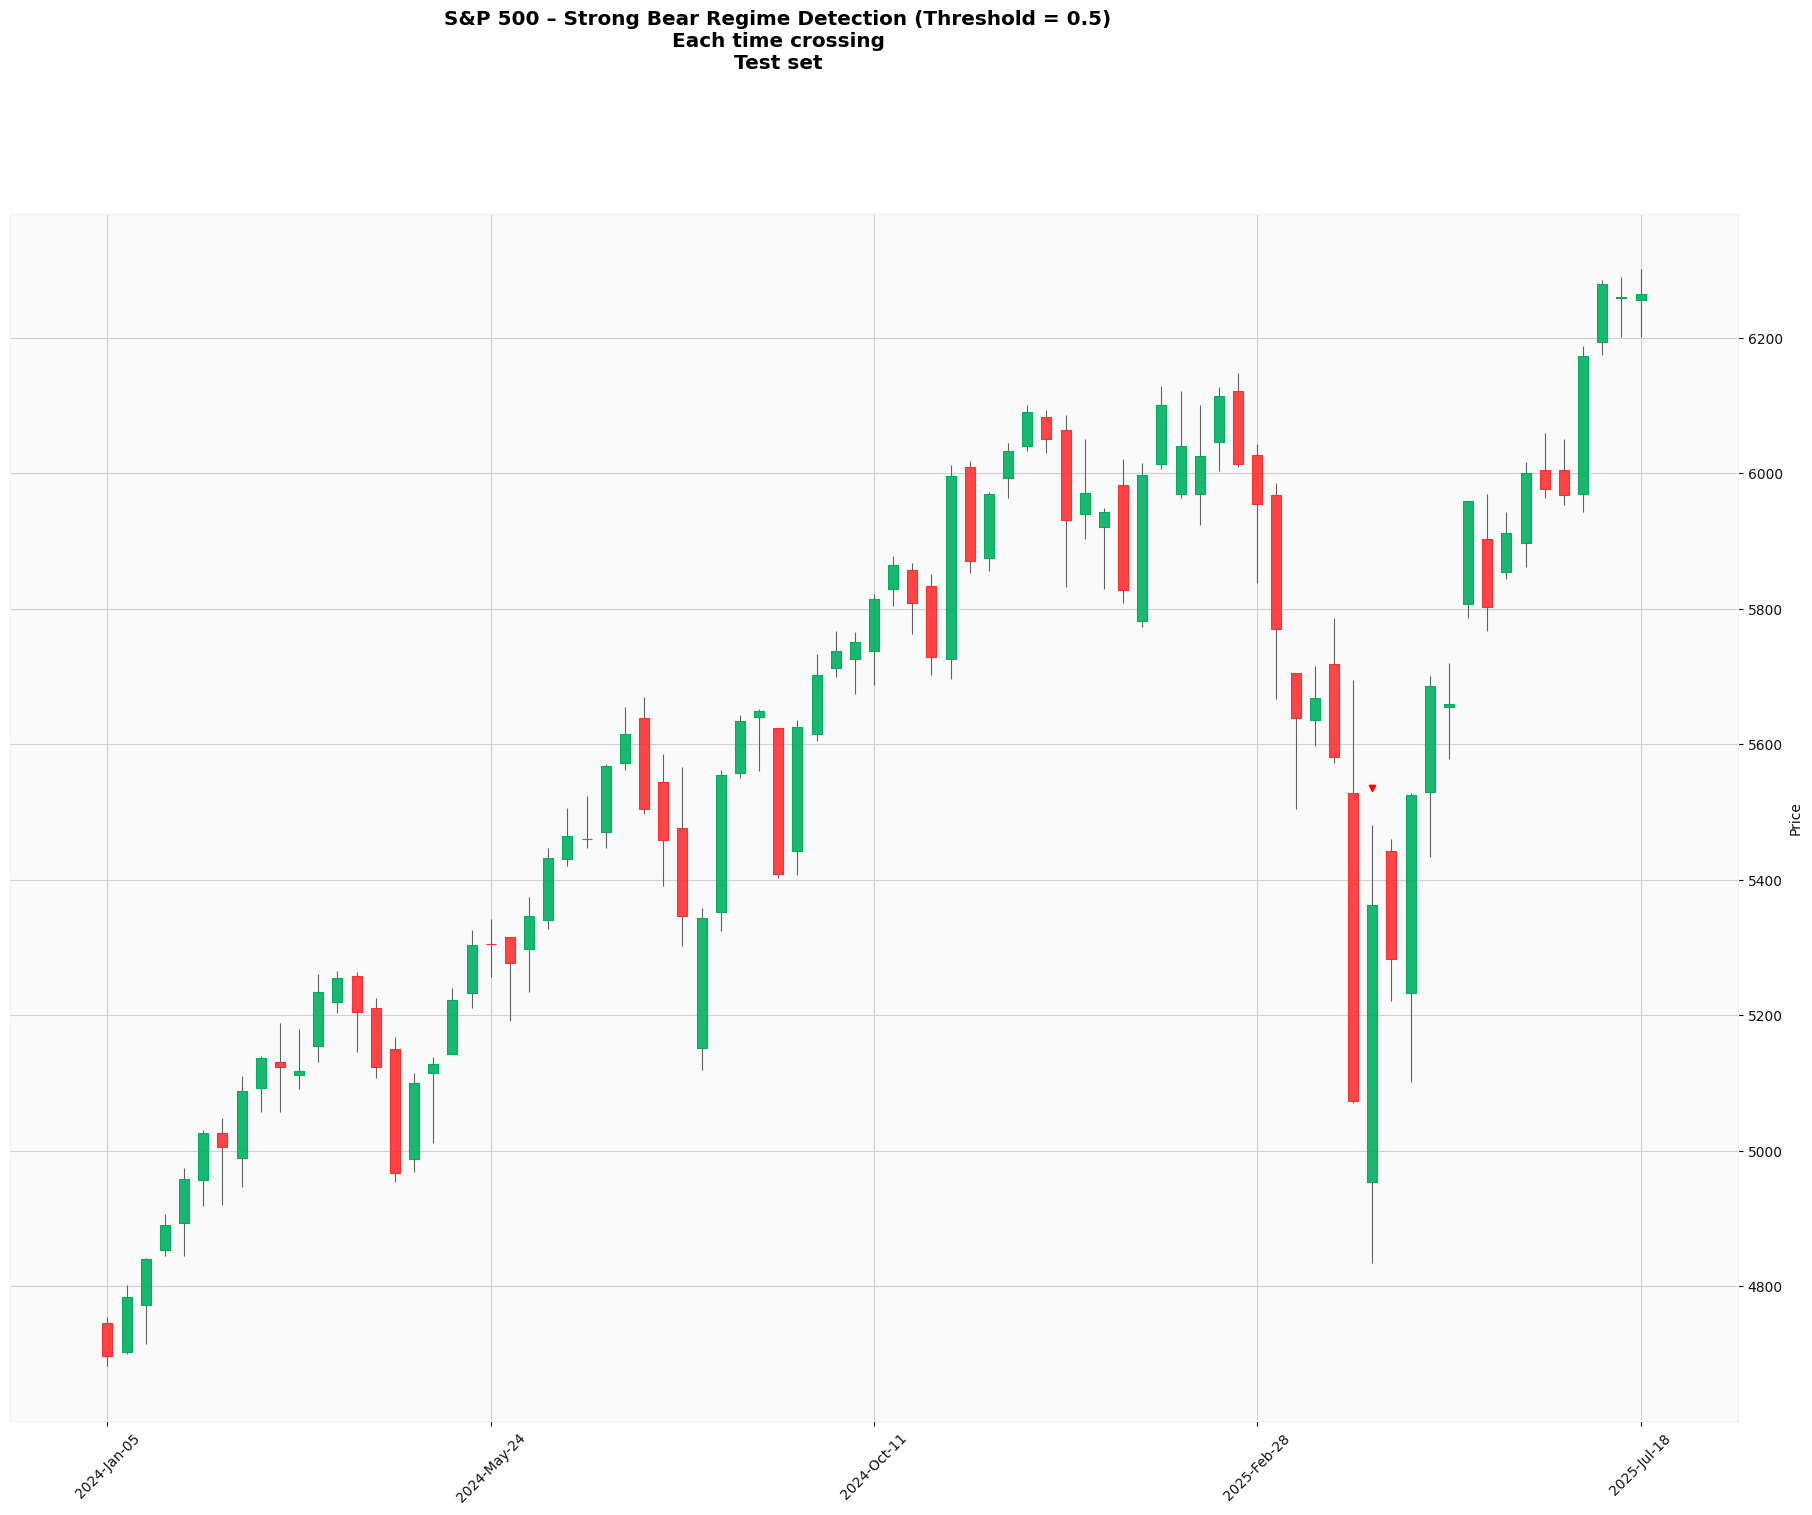

In [40]:
import mplfinance as mpf
import numpy as np

# Convert 'date' column to datetime if not already
df_test['date'] = pd.to_datetime(df_test['date'])

# Set 'date' column as index (a DatetimeIndex)
df_test_dt = df_test.set_index('date').copy()

returns = df_test_dt['return'].values  # use the datetime-indexed df
gamma_t = functions.compute_gamma_t(returns, mu_post, sigma_post, pi_post)

strong_bear_threshold = 0.5
strong_bear_mask = gamma_t[:, 0] > strong_bear_threshold

marker_positions = np.where(strong_bear_mask, df_test_dt['high'] * 1.01, np.nan)

apdict = mpf.make_addplot(marker_positions, type='scatter',
                          markersize=20, marker='v', color='red')

mpf.plot(df_test_dt, type='candle', style='yahoo', addplot=apdict,
         title=f'S&P 500 – Strong Bear Regime Detection (Threshold = {strong_bear_threshold})\nEach time crossing\nTest set',
         ylabel='Price', volume=False, figscale=3)


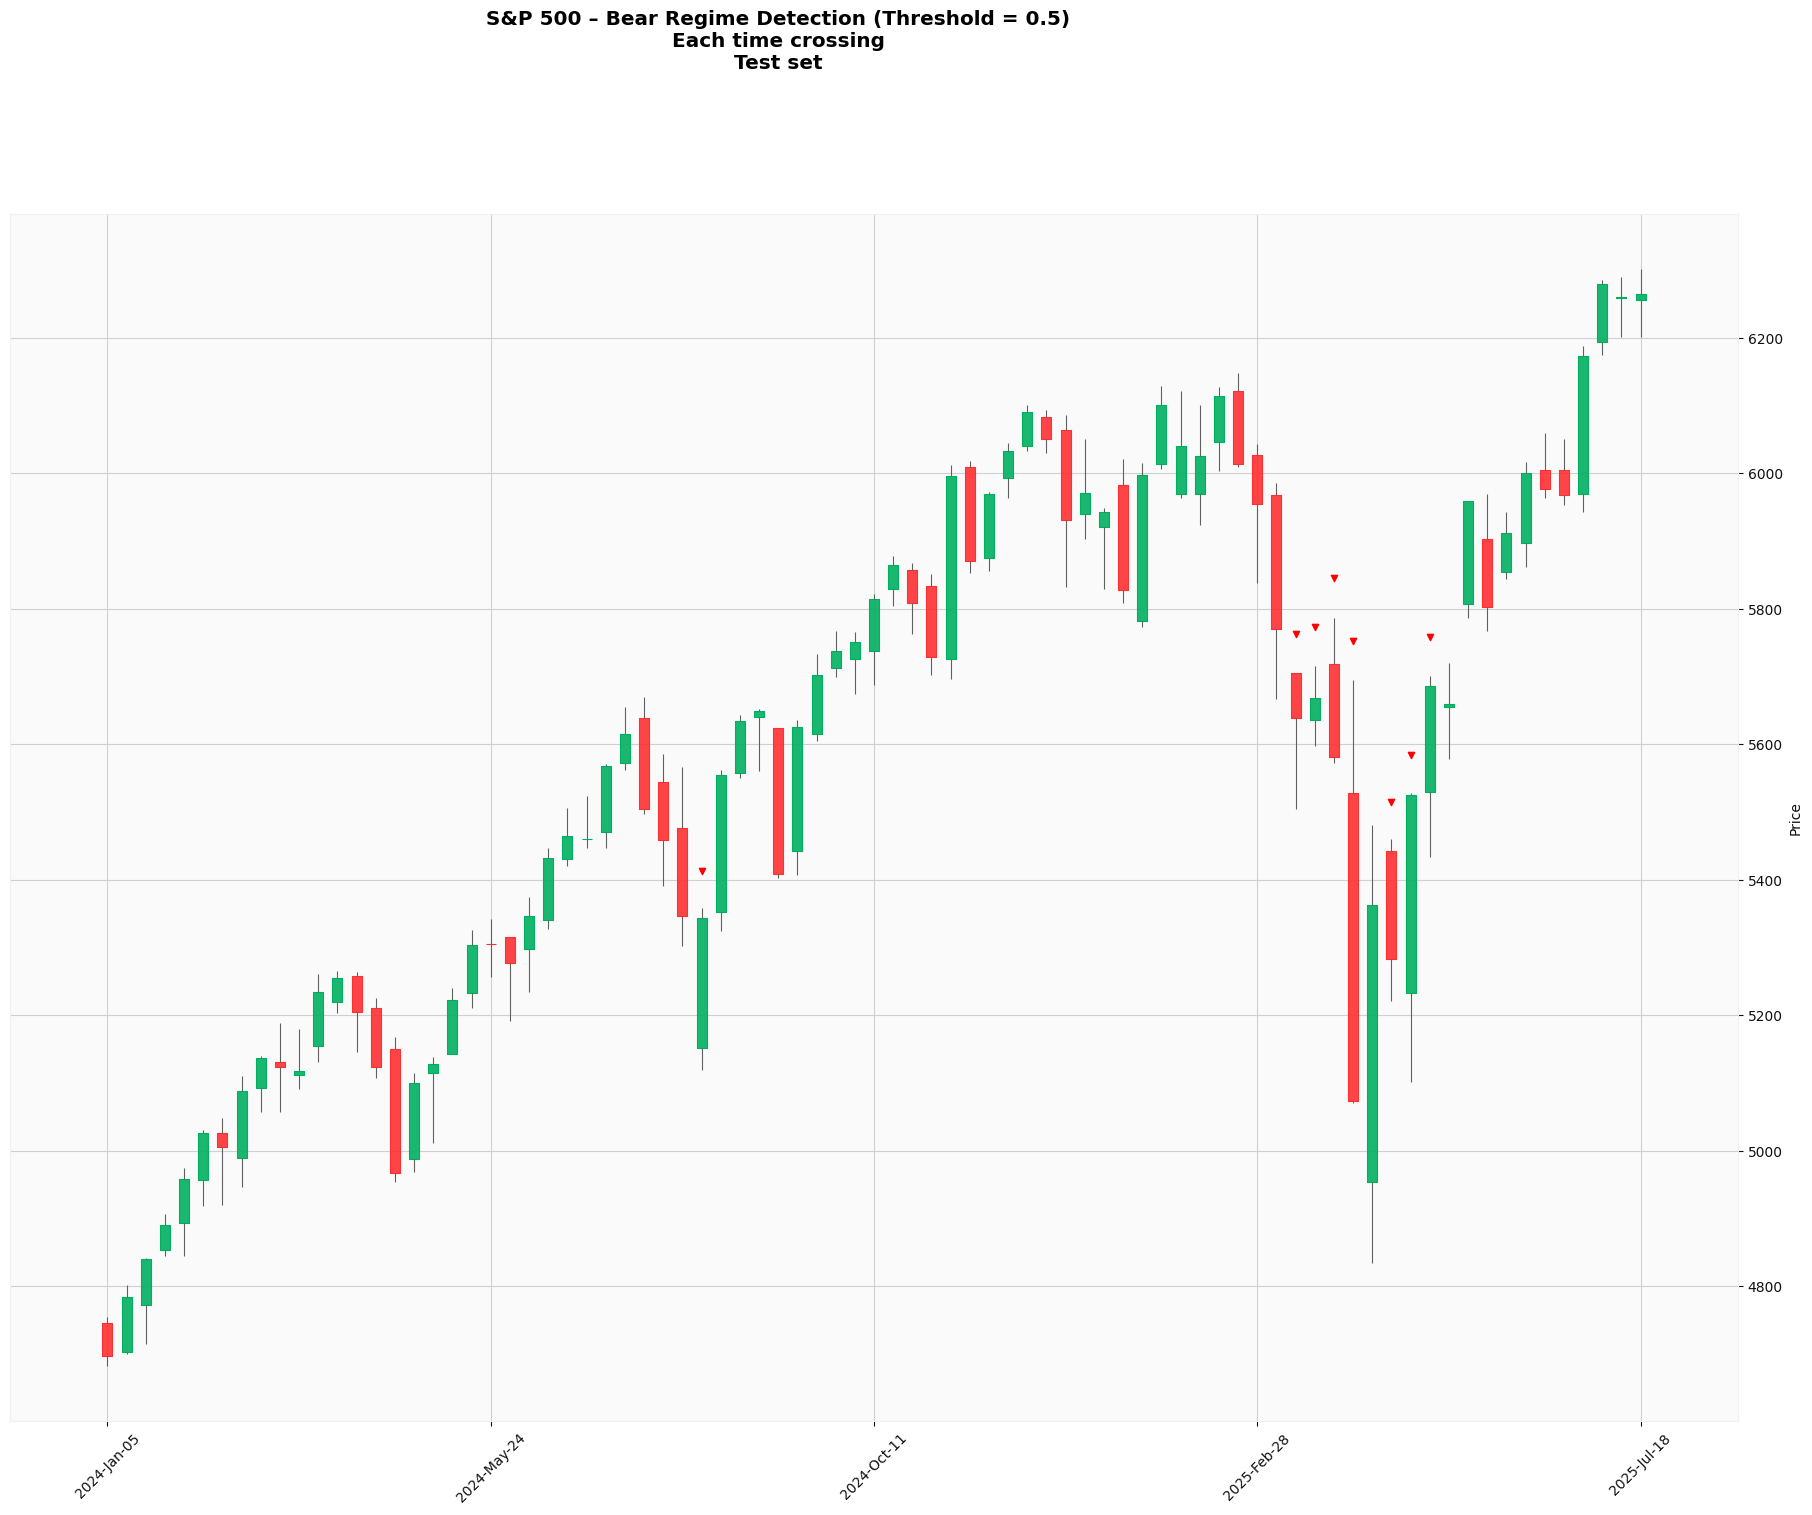

In [41]:
import mplfinance as mpf
import numpy as np

# Convert 'date' column to datetime if not already
df_test['date'] = pd.to_datetime(df_test['date'])

# Set 'date' column as index (a DatetimeIndex)
df_test_dt = df_test.set_index('date').copy()

returns = df_test_dt['return'].values  # use the datetime-indexed df
gamma_t = functions.compute_gamma_t(returns, mu_post, sigma_post, pi_post)

bear_threshold = 0.5
bear_mask = gamma_t[:, 1] > bear_threshold

marker_positions = np.where(bear_mask, df_test_dt['high'] * 1.01, np.nan)

apdict = mpf.make_addplot(marker_positions, type='scatter',
                          markersize=20, marker='v', color='red')

mpf.plot(df_test_dt, type='candle', style='yahoo', addplot=apdict,
         title=f'S&P 500 – Bear Regime Detection (Threshold = {bear_threshold})\nEach time crossing\nTest set',
         ylabel='Price', volume=False, figscale=3)


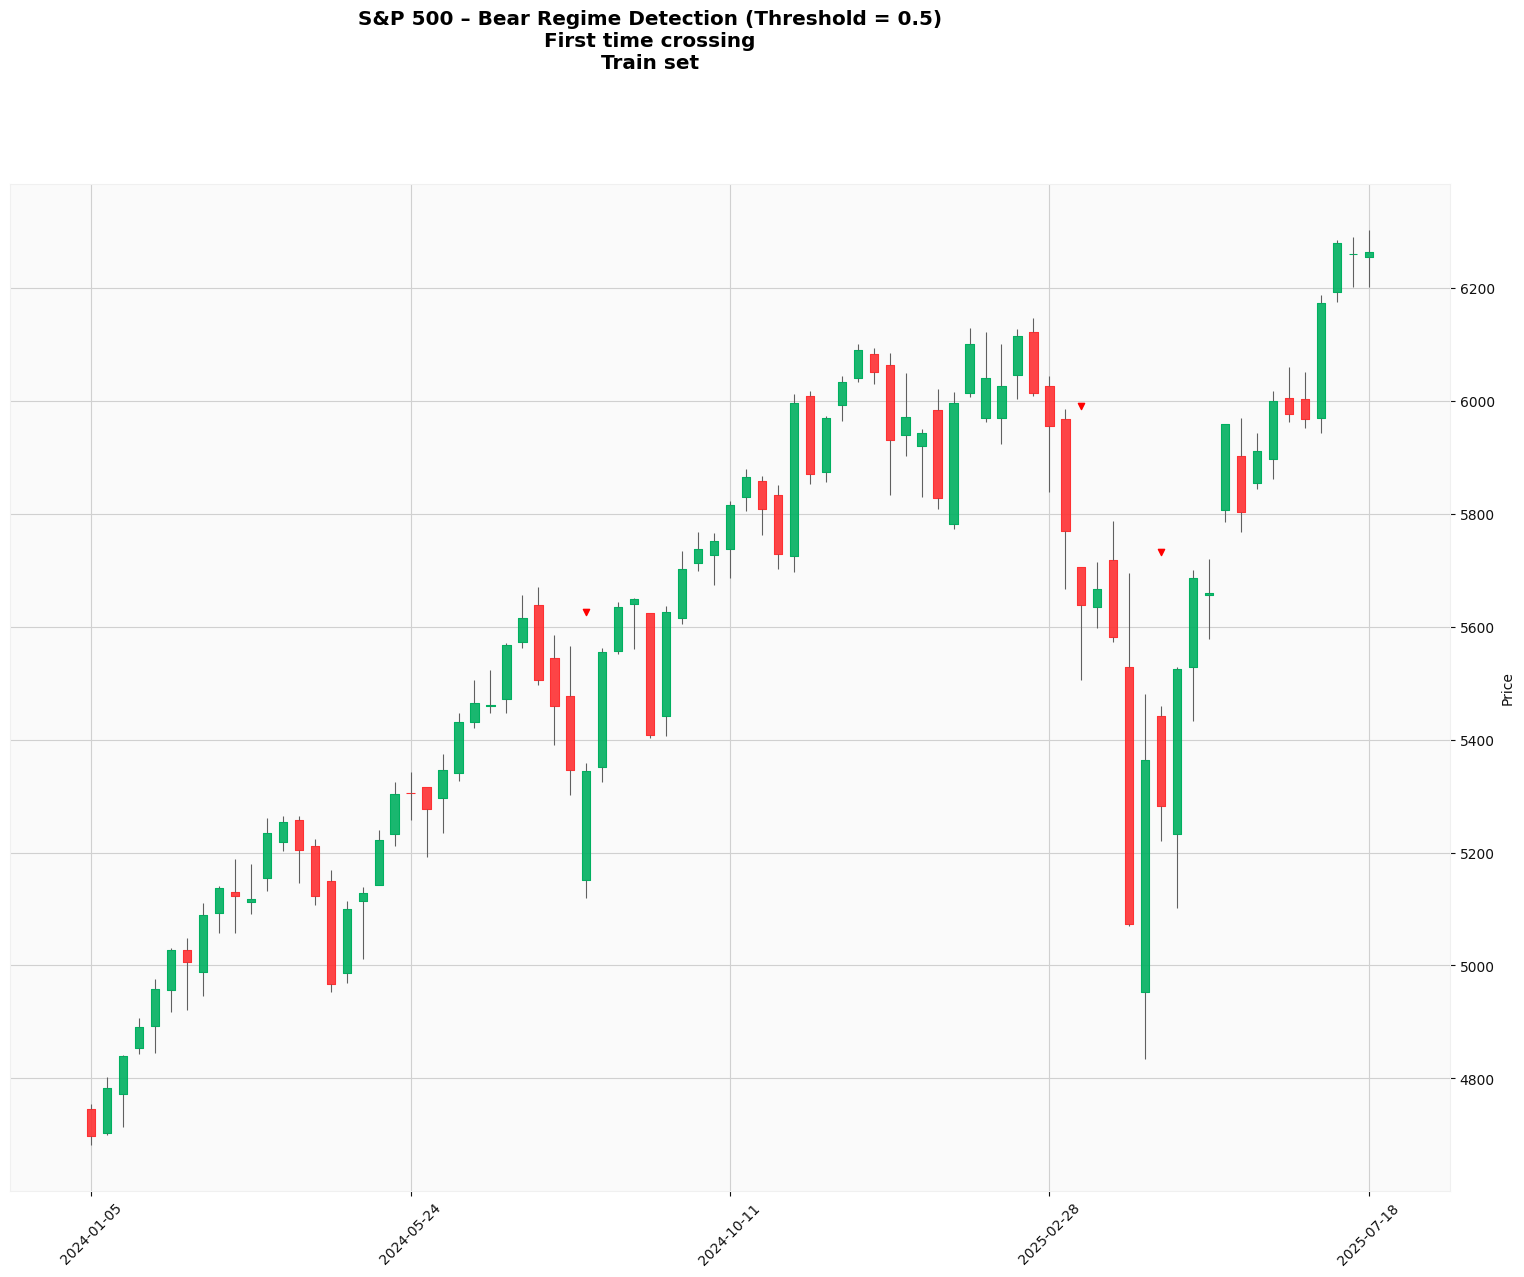

In [42]:
import pandas as pd
import numpy as np
import mplfinance as mpf

# upward crossing of
threshold = 0.5

functions.plot_upward_crossings(
    df_test,
    gamma_probs=gamma_t[:, 1], # bear
    threshold=threshold,
    marker_type='v',
    marker_size=20,
    marker_color='red',
    type = 'candle',
    title=f'S&P 500 – Bear Regime Detection (Threshold = {threshold})\nFirst time crossing\nTrain set',
    figscale=2.5
)


# 📊 Results

In [43]:
# Annotate signals
gamma_test_t = functions.compute_gamma_t(df_test['return'].values, mu_post, sigma_post, pi_post)

df_test_annotated = functions.annotate_signals_and_returns(
    df_ohlc=df_test,
    gamma_probs=gamma_test_t[:, 0],
    threshold=0.5,
    horizon=1
)

df_test_annotated

,date,open,high,low,close,volume,wma_open,detrended_open,range_factor,return,gamma,signal,future_return
1252,2024-01-05,4745.200195,4754.330078,4682.109863,4697.240234,15253660000,4488.015137,0.062461,1.015425,0.063425,0.006985,0,NaN
1253,2024-01-12,4703.700195,4802.399902,4699.819824,4783.830078,18017190000,4505.882672,0.048058,1.021826,0.049107,0.006338,0,NaN
1254,2024-01-19,4772.350098,4842.069824,4714.819824,4839.810059,16495350000,4527.953704,0.059138,1.026989,0.060734,0.006749,0,NaN
1255,2024-01-26,4853.419922,4906.689941,4844.049805,4890.970215,19914270000,4555.279223,0.071879,1.012931,0.072809,0.008350,0,NaN
1256,2024-02-02,4892.950195,4975.290039,4845.149902,4958.609863,20417850000,4584.649635,0.074127,1.026860,0.076118,0.009088,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328,2025-06-20,6004.000000,6050.830078,5952.560059,5967.839844,22625380000,5751.966766,0.046633,1.016509,0.047403,0.006353,0,NaN
1329,2025-06-27,5969.669922,6187.680176,5943.229980,6173.069824,29409290000,5765.072714,0.037848,1.041131,0.039405,0.006676,0,NaN
1330,2025-07-04,6193.359863,6284.649902,6174.970215,6279.350098,21082030000,5794.664469,0.074290,1.017762,0.075610,0.008964,0,NaN
1331,2025-07-11,6259.040039,6290.220215,6201.000000,6259.750000,25812670000,5828.344528,0.080138,1.014388,0.081292,0.010614,0,NaN


In [44]:
# Bear
gamma_train_t = functions.compute_gamma_t(df_train['return'].values, mu_post, sigma_post, pi_post)
gamma_test_t = functions.compute_gamma_t(df_test['return'].values, mu_post, sigma_post, pi_post)

table_bear = functions.generate_performance_table(
    df_train,
    df_test,
    gamma_train_t,
    gamma_test_t,
    regime_idx=1,       # bear
    threshold=0.5,
    horizons=[1, 4, 6, 10]
)

# Display
print("Bear")
from IPython.display import display, HTML
display(HTML(table_bear.to_html(classes='table table-striped table-hover table-condensed')))

# Strong Bear
table_strong_bear = functions.generate_performance_table(
    df_train,
    df_test,
    gamma_train_t,
    gamma_test_t,
    regime_idx=0,       # strong bear
    threshold=0.5,
    horizons=[1, 4, 6, 8]
)

# Display
print("Strong Bear")
from IPython.display import display, HTML
display(HTML(table_strong_bear.to_html(classes='table table-striped table-hover table-condensed')))

Bear


,Train Signals,Train Negatives,Train Negative Ratio,Test Signals,Test Negatives,Test Negative Ratio
Horizon,,,,,,
1,75,41,54.67%,3,0,0.00%
4,75,35,46.67%,3,1,33.33%
6,75,28,37.33%,3,1,33.33%
10,75,35,46.67%,3,0,0.00%


Strong Bear


,Train Signals,Train Negatives,Train Negative Ratio,Test Signals,Test Negatives,Test Negative Ratio
Horizon,,,,,,
1,13,6,46.15%,1,1,100.00%
4,13,2,15.38%,1,0,0.00%
6,13,4,30.77%,1,0,0.00%
8,13,3,23.08%,1,0,0.00%
